# MLP Classification Pipeline - PyTorch Only

## Preprocessing

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv('KlasifikasiUTS.csv')

y = df['Class']
X = df.drop(columns=['Class', 'Time'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Dataset & Dataloader

In [3]:

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train_scaled, y_train)
test_dataset = CustomDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Model

In [4]:

def build_model(input_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(64, 1),
        nn.Sigmoid()
    )

model = build_model(X_train_scaled.shape[1]).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCELoss()


## Training

In [5]:

epochs = 50
best_loss = np.inf
patience = 10
counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}")

    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

model.load_state_dict(torch.load("best_model.pt"))


Epoch 1/50, Loss: 0.0189
Epoch 2/50, Loss: 0.0047
Epoch 3/50, Loss: 0.0044
Epoch 4/50, Loss: 0.0040
Epoch 5/50, Loss: 0.0039
Epoch 6/50, Loss: 0.0036
Epoch 7/50, Loss: 0.0035
Epoch 8/50, Loss: 0.0035
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0033
Epoch 11/50, Loss: 0.0033
Epoch 12/50, Loss: 0.0032
Epoch 13/50, Loss: 0.0031
Epoch 14/50, Loss: 0.0031
Epoch 15/50, Loss: 0.0032
Epoch 16/50, Loss: 0.0030
Epoch 17/50, Loss: 0.0030
Epoch 18/50, Loss: 0.0029
Epoch 19/50, Loss: 0.0030
Epoch 20/50, Loss: 0.0030
Epoch 21/50, Loss: 0.0029
Epoch 22/50, Loss: 0.0029
Epoch 23/50, Loss: 0.0029
Epoch 24/50, Loss: 0.0028
Epoch 25/50, Loss: 0.0028
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0027
Epoch 29/50, Loss: 0.0027
Epoch 30/50, Loss: 0.0027
Epoch 31/50, Loss: 0.0027
Epoch 32/50, Loss: 0.0027
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0025
Epoch 35/50, Loss: 0.0027
Epoch 36/50, Loss: 0.0026
Epoch 37/50, Loss: 0.0025
Epoch 38/50, Loss: 0.0026
Epoch 39/50, Loss: 0.

<All keys matched successfully>

## Evaluation

PyTorch MLP - Accuracy: 0.9994 Precision: 0.8000 Recall: 0.8571 F1-score: 0.8276


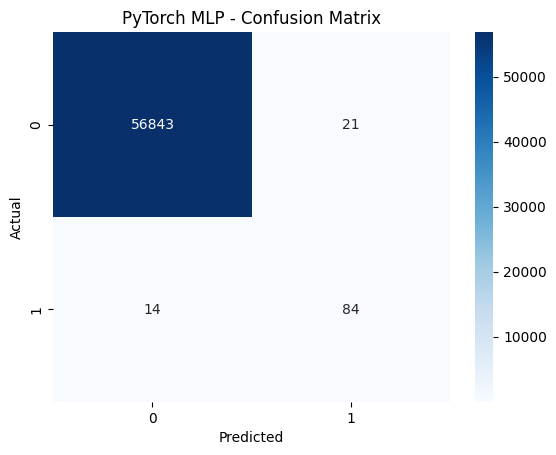

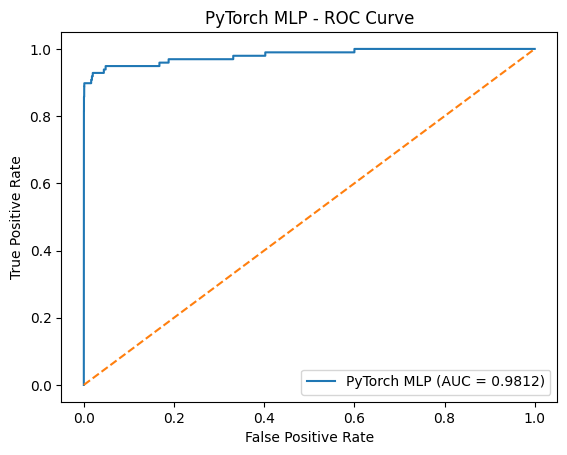

In [6]:

def evaluate_model(model, test_loader, y_test, name="PyTorch MLP"):
    model.eval()
    y_true = []
    y_pred = []
    y_pred_prob = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs.cpu().numpy() > 0.5).astype(int)

            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.flatten())
            y_pred_prob.extend(outputs.cpu().numpy().flatten())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{name} - Accuracy: {acc:.4f} Precision: {prec:.4f} Recall: {rec:.4f} F1-score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve')
    plt.legend()
    plt.show()

evaluate_model(model, test_loader, y_test)


Klasifikasi di atas adalah klasifikasi biner dengan class 0 dan 1
Fitur di-scale menggunakan Standardscaler dan di split 80:20

Dataset dibungkus menjadi PyTorch Dataset

# MODEL
MLP (Multi-Layer Perceptron), arsitektur:

Linear( input_dim → 128 ) → BatchNorm → ReLU → Dropout(0.5)

Linear(128 → 64) → BatchNorm → ReLU → Dropout(0.5)

Linear(64 → 1) → Sigmoid (karena klasifikasi biner)

Optimizer = AdamW (modern, ada weight decay)

Loss = BCELoss (binary cross-entropy)

# MATRIKS EVALUASI
Model dapat menggenarlisasi dengan baik karena AUC tinggi (~0.98) dan F1-score balance (0.82). Precision dan recall juga tinggi.